In [131]:
from vecstack import stacking
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score #works
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
#from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC
from collections import Counter #for Smote, 


# Special settings for Python notebook
%matplotlib inline

# Ignore FutureWarnings related to internal pandas and np code
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [97]:

trainfile = r'C:\Users\farha\Downloads\trainTA.csv'
train_data = pd.read_csv(trainfile)

#train_data = pd.read_csv("C:/Users/admin/Downloads/Insurance Fraud - TRAIN-3000(1).csv")


testfile = r'C:\Users\farha\Downloads\testTA.csv'
test_data = pd.read_csv(testfile)

#test_data = pd.read_csv("C:/Users/admin/Downloads/Insurance Fraud -TEST-12900(1).csv")

print('Shape of train data')
print(train_data.shape)
print(test_data.shape)
print(train_data.head())    


Shape of train data
(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCo

In [98]:
#To do encoding just for the catogerical variables
from sklearn import preprocessing


for f in train_data.columns:
    if train_data[f].dtype=='object':
        print(f)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_data[f].values) + list(test_data[f].values))
        train_data[f] = lbl.transform(list(train_data[f].values))
        test_data[f] = lbl.transform(list(test_data[f].values))

MSZoning
Street
Alley
LotShape
LandContour
Utilities
LotConfig
LandSlope
Neighborhood
Condition1
Condition2
BldgType
HouseStyle
RoofStyle
RoofMatl
Exterior1st
Exterior2nd
MasVnrType
ExterQual
ExterCond
Foundation
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinType2
Heating
HeatingQC
CentralAir
Electrical
KitchenQual
Functional
FireplaceQu
GarageType
GarageFinish
GarageQual
GarageCond
PavedDrive
PoolQC
Fence
MiscFeature
SaleType
SaleCondition


# Traindata

In [99]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in train_data.columns if train_data[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(train_data[feature].isnull().mean(), 4),  ' % missing values')

LotFrontage 0.1774  % missing values
MasVnrArea 0.0055  % missing values
GarageYrBlt 0.0555  % missing values


In [100]:
## Replace missing value with a new label
features_nan=[feature for feature in train_data.columns if train_data[feature].isnull().sum()>1 and train_data[feature].dtypes=='O']

def replace_cat_feature(train_data,features_nan):
    data=train_data.copy()
    data[features_nan]=data[features_nan].fillna('Missing')
    return data

dataset=replace_cat_feature(train_data,features_nan)

dataset[features_nan].isnull().sum()

Series([], dtype: float64)

In [101]:
## Now lets check for numerical variables the contains missing values
numerical_with_nan=[feature for feature in dataset.columns if dataset[feature].isnull().sum()>1 and dataset[feature].dtypes!='O']

## We will print the numerical nan variables and percentage of missing values

for feature in numerical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(dataset[feature].isnull().mean(),4)))

LotFrontage: 0.1774% missing value
MasVnrArea: 0.0055% missing value
GarageYrBlt: 0.0555% missing value


In [102]:
## Replacing the numerical Missing Values

for feature in numerical_with_nan:
    ## We will replace by using median since there are outliers
    median_value=dataset[feature].median()
    
    ## create a new feature to capture nan values
    dataset[feature+'nan']=np.where(dataset[feature].isnull(),1,0)
    dataset[feature].fillna(median_value,inplace=True)
    
dataset[numerical_with_nan].isnull().sum()
    

LotFrontage    0
MasVnrArea     0
GarageYrBlt    0
dtype: int64

In [103]:
# feature_scale=[feature for feature in dataset.columns if feature not in ['Id','SalePrice']]

# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# scaler.fit(dataset[feature_scale])

In [104]:
# scaler.transform(dataset[feature_scale])

In [105]:
# # transform the train and test set, and add on the Id and SalePrice variables
# data = pd.concat([dataset[['Id', 'SalePrice']].reset_index(drop=True),
#                     pd.DataFrame(scaler.transform(dataset[feature_scale]), columns=feature_scale)],
#                     axis=1)


In [106]:
dataset = dataset.drop(['LotFrontage','MasVnrArea','GarageYrBlt'], axis =1)

In [107]:
test_data.isnull().sum().sort_values(ascending = False).head(20)

LotFrontage     227
GarageYrBlt      78
MasVnrArea       15
BsmtFullBath      2
BsmtHalfBath      2
GarageCars        1
TotalBsmtSF       1
BsmtUnfSF         1
BsmtFinSF2        1
BsmtFinSF1        1
GarageArea        1
KitchenQual       0
Fireplaces        0
Functional        0
TotRmsAbvGrd      0
Id                0
KitchenAbvGr      0
BedroomAbvGr      0
HalfBath          0
FireplaceQu       0
dtype: int64

# Testdata

In [108]:
## Here we will check the percentage of nan values present in each feature
## 1 -step make the list of features which has missing values
features_with_na=[features for features in test_data.columns if test_data[features].isnull().sum()>1]
## 2- step print the feature name and the percentage of missing values

for feature in features_with_na:
    print(feature, np.round(test_data[feature].isnull().mean(), 4),  ' % missing values')

LotFrontage 0.1556  % missing values
MasVnrArea 0.0103  % missing values
BsmtFullBath 0.0014  % missing values
BsmtHalfBath 0.0014  % missing values
GarageYrBlt 0.0535  % missing values


In [109]:
## Replace missing value with a new label
features_nan=[feature for feature in test_data.columns if test_data[feature].isnull().sum()>1 and test_data[feature].dtypes=='O']

def replace_cat_feature(test_data,features_nan):
    testdata=test_data.copy()
    testdata[features_nan]=testdata[features_nan].fillna('Missing')
    return testdata

testdataset=replace_cat_feature(test_data,features_nan)

testdataset[features_nan].isnull().sum()

Series([], dtype: float64)

In [110]:
## Now lets check for numerical variables the contains missing values
numerical_with_nan=[feature for feature in testdataset.columns if testdataset[feature].isnull().sum()>0 and testdataset[feature].dtypes!='O']

## We will print the numerical nan variables and percentage of missing values

for feature in numerical_with_nan:
    print("{}: {}% missing value".format(feature,np.around(testdataset[feature].isnull().mean(),4)))

LotFrontage: 0.1556% missing value
MasVnrArea: 0.0103% missing value
BsmtFinSF1: 0.0007% missing value
BsmtFinSF2: 0.0007% missing value
BsmtUnfSF: 0.0007% missing value
TotalBsmtSF: 0.0007% missing value
BsmtFullBath: 0.0014% missing value
BsmtHalfBath: 0.0014% missing value
GarageYrBlt: 0.0535% missing value
GarageCars: 0.0007% missing value
GarageArea: 0.0007% missing value


In [111]:
## Replacing the numerical Missing Values

for feature in numerical_with_nan:
    ## We will replace by using median since there are outliers
    median_value=testdataset[feature].median()
    
    ## create a new feature to capture nan values
    testdataset[feature+'nan']=np.where(testdataset[feature].isnull(),1,0)
    testdataset[feature].fillna(median_value,inplace=True)
    
testdataset[numerical_with_nan].isnull().sum()
    

LotFrontage     0
MasVnrArea      0
BsmtFinSF1      0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
GarageYrBlt     0
GarageCars      0
GarageArea      0
dtype: int64

In [112]:
for i in testdataset:
    if i not in dataset:
        print(i)

LotFrontage
MasVnrArea
GarageYrBlt
BsmtFinSF1nan
BsmtFinSF2nan
BsmtUnfSFnan
TotalBsmtSFnan
BsmtFullBathnan
BsmtHalfBathnan
GarageCarsnan
GarageAreanan


In [113]:
# feature_scale=[feature for feature in testdataset.columns if feature not in ['Id','SalePrice']]

# from sklearn.preprocessing import MinMaxScaler
# scaler=MinMaxScaler()
# scaler.fit(testdataset[feature_scale])

In [114]:
# scaler.transform(testdataset[feature_scale])
# # transform the train and test set, and add on the Id and SalePrice variables
# testdataset = pd.concat([testdataset[['Id']].reset_index(drop=True),
#                     pd.DataFrame(scaler.transform(testdataset[feature_scale]), columns=feature_scale)],
#                     axis=1)


In [115]:
testdataset

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,MasVnrAreanan,BsmtFinSF1nan,BsmtFinSF2nan,BsmtUnfSFnan,TotalBsmtSFnan,BsmtFullBathnan,BsmtHalfBathnan,GarageYrBltnan,GarageCarsnan,GarageAreanan
0,1461,20,2,80.0,11622,1,2,3,3,0,...,0,0,0,0,0,0,0,0,0,0
1,1462,20,3,81.0,14267,1,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
2,1463,60,3,74.0,13830,1,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
3,1464,60,3,78.0,9978,1,2,0,3,0,...,0,0,0,0,0,0,0,0,0,0
4,1465,120,3,43.0,5005,1,2,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,4,21.0,1936,1,2,3,3,0,...,0,0,0,0,0,0,0,1,0,0
1455,2916,160,4,21.0,1894,1,2,3,3,0,...,0,0,0,0,0,0,0,0,0,0
1456,2917,20,3,160.0,20000,1,2,3,3,0,...,0,0,0,0,0,0,0,0,0,0
1457,2918,85,3,62.0,10441,1,2,3,3,0,...,0,0,0,0,0,0,0,1,0,0


In [129]:
numerical_features = [feature for feature in dataset.columns if dataset[feature].dtypes != 'O']
year_feature = [feature for feature in numerical_features if 'Yr' in feature or 'Year' in feature]

discrete_feature=[feature for feature in numerical_features if len(dataset[feature].unique())<25 and feature not in year_feature+['Id']]


continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature+year_feature+['Id']]
print("Continuous feature Count {}".format(len(continuous_feature)))

Continuous feature Count 15


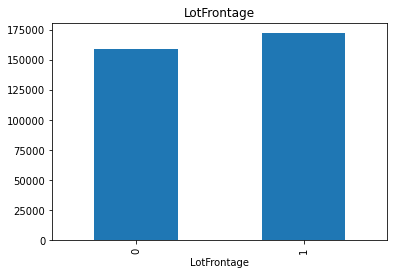

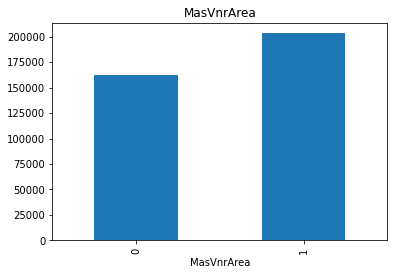

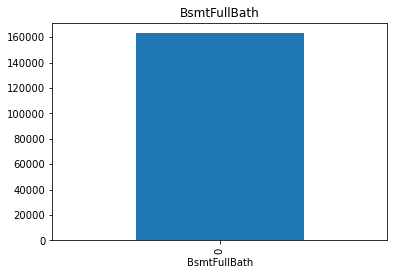

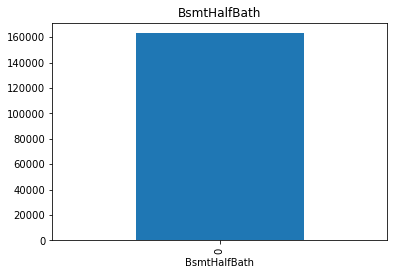

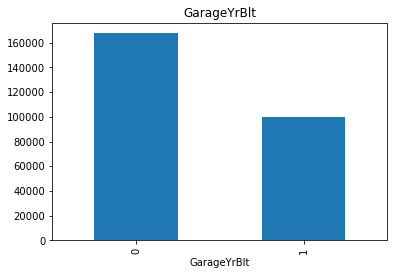

In [135]:
for feature in features_with_na:
    data = train_data.copy()
    
    # let's make a variable that indicates 1 if the observation was missing or zero otherwise
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    
    # let's calculate the mean SalePrice where the information is missing or present
    data.groupby(feature)['SalePrice'].median().plot.bar()
    plt.title(feature)
    plt.show()

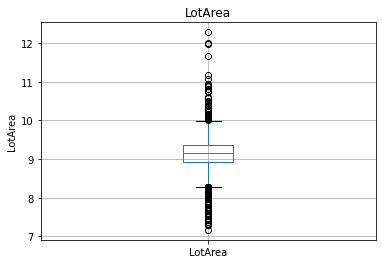

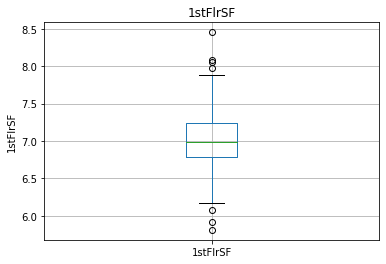

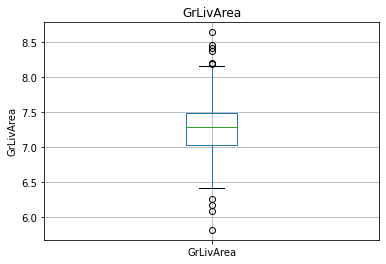

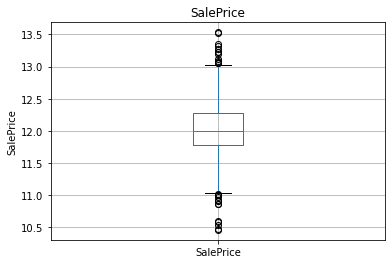

In [126]:
import matplotlib.pyplot as plt
for feature in continuous_feature:
    data=dataset.copy()
    if 0 in data[feature].unique():
        pass
    else:
        data[feature]=np.log(data[feature])
        data.boxplot(column=feature)
        plt.ylabel(feature)
        plt.title(feature)
        plt.show()
        

In [128]:
TrainCols = list(dataset.columns.values)
TestCols = list(testdataset.columns.values)
print(TrainCols)
print(TestCols)

['Id', 'MSSubClass', 'MSZoning', 'LotArea', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'PoolQC', 'Fence', 'MiscFeature', 'MiscVal', 'MoSold

In [38]:
# Seperate Target column from Train Data
Xtrain = dataset.drop(labels= ['SalePrice'], axis = 1)
Ytrain = dataset[['SalePrice']].copy()
print("Train Set shape:")
print(Xtrain.shape)
print(Ytrain.shape)
Xtest = testdataset.drop(['LotFrontage',
'MasVnrArea',
'GarageYrBlt',
'BsmtFullBathnan',
'BsmtHalfBathnan',
'BsmtFinSF1nan',
'BsmtFinSF2nan',
'BsmtUnfSFnan',
'TotalBsmtSFnan',
'GarageCarsnan',
'GarageAreanan'], axis =1)
print(Xtest.shape)

Train Set shape:
(1460, 80)
(1460, 1)
(1459, 80)


In [39]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size=0.3, random_state=0) 

In [40]:
X_test1

,Id,MSSubClass,MSZoning,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,LotFrontagenan,MasVnrAreanan,GarageYrBltnan
529,530,20,3,32668,1,2,0,3,0,1,...,4,4,0,3,2007,8,2,1,1,0
491,492,50,3,9490,1,2,3,3,0,4,...,2,4,0,8,2006,8,4,0,0,0
459,460,50,3,7015,1,2,0,0,0,0,...,4,4,0,7,2009,8,4,1,0,0
279,280,60,3,10005,1,2,3,3,0,4,...,4,4,0,3,2008,8,4,0,0,0
655,656,160,4,1680,1,2,3,3,0,4,...,4,4,0,3,2010,8,3,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,272,20,3,39104,1,2,0,2,0,1,...,4,4,0,4,2008,8,4,0,0,0
445,446,20,3,9855,1,2,3,3,0,0,...,2,4,0,11,2009,0,4,0,0,0
654,655,20,3,10437,1,2,0,3,0,4,...,4,4,0,8,2008,8,4,0,0,0
1280,1281,20,3,9808,1,2,0,3,0,4,...,4,4,0,3,2009,8,4,0,0,0


In [149]:
#Decision Tree Regressor ========================================================================
#CONSTRUCT DEFAULT DECISION TREE AND OBTAIN RESPECTIVE ACCURACY 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

clf = DecisionTreeRegressor()
clf.fit(X_train1, y_train)
clf_predict_Train=clf.predict(X_train1)

#clf.feature_importances_
mean_squared_error(y_train,clf_predict_Train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,clf_predict_Train)))
clf_predict_Test=clf.predict(X_test1)
mean_squared_error(y_test,clf_predict_Test)
print("RMSE (Test Data) for Decision Tree:{0:10f}".format(mean_squared_error(y_test,clf_predict_Test)))


RMSE (training) for Decision Tree:  0.000000
RMSE (Test Data) for Decision Tree:1576340945.349315


In [150]:
#Cross Validation for Decision Tree Regressor
from sklearn.model_selection import cross_val_score
CV_RMSE_DTR = cross_val_score(clf, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_DTR)
print("Mean AUC Score - Decision Tree Regressor: ",CV_RMSE_DTR.mean())


[-43003.41476384 -40502.88144956 -56599.59655875 -38855.73046206
 -36782.89000257]
Mean AUC Score - Decision Tree Regressor:  -43148.902647355724


In [42]:
clf_predict_Test=clf.predict(Xtest)

In [43]:
submission=testdataset[['Id']]
submission['SalePrice']=clf_predict_Test
submission.to_csv("results2.1.csv", index = None)

In [144]:
#Random Forest Regressor==============================================================================
#=================================================================================================
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor()
rfc.fit(X_train1, y_train)
rfc_predict_Train=rfc.predict(X_train1)

mean_squared_error(y_train,rfc_predict_Train)
print("RMSE (training) for Random Forest:{0:10f}".format(mean_squared_error(y_train,rfc_predict_Train)))
rfc_predict_Test=rfc.predict(X_test1)
mean_squared_error(y_test,rfc_predict_Test)
print("RMSE (Test Data) for Random Forest:{0:10f}".format(mean_squared_error(y_test,rfc_predict_Test)))



RMSE (training) for Random Forest:125340915.064442
RMSE (Test Data) for Random Forest:888679717.880478


In [151]:
from sklearn.model_selection import cross_val_score
CV_RMSE_RFR = cross_val_score(rfc, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_RFR)
print("Mean AUC Score - Random Forest Regressor: ",CV_RMSE_RFR.mean())


[-35840.0983158  -27926.78488594 -34311.74860703 -28379.11215052
 -23117.40416425]
Mean AUC Score - Random Forest Regressor:  -29915.029624705938


In [46]:
rfc_predict_test = rfc.predict(Xtest)

In [47]:
submission=testdataset[['Id']]
submission['SalePrice']=rfc_predict_test
submission.to_csv("results2.2.csv", index = None)

In [49]:
from sklearn.linear_model import LinearRegression
lr=LinearRegression()
lr.fit(X_train1,y_train)
lr_predict_train=lr.predict(X_train1)

mean_squared_error(y_train,lr_predict_train)
print("RMSE (training) for linear regressor:{0:10f}".format(mean_squared_error(y_train,lr_predict_train)))
lr_predict_test = lr.predict(X_test1)
mean_squared_error(y_test,lr_predict_test)
print("RMSE (Test) for all linear regressor:{}".format(mean_squared_error(y_test,lr_predict_test)))

RMSE (training) for linear regressor:718125769.559161
RMSE (Test) for all linear regressor:2249137472.53578


In [50]:
lr_predict_test1 = lr.predict(Xtest)

In [51]:
submission=testdataset[['Id']]
submission['SalePrice']=lr_predict_test1
submission.to_csv("results2.3.csv", index = None)

In [153]:
from sklearn.neural_network import MLPRegressor
mlp=MLPRegressor()
mlp.fit(X_train1,y_train)
mlp_predict_train = mlp.predict(X_train1)

mean_squared_error(y_train,mlp_predict_train)
print("RMSE (Train) for MLP :{}",mean_squared_error(y_train,mlp_predict_train))
mlp_predict_test = mlp.predict(X_test1)
mean_squared_error(y_test,mlp_predict_test)
print("RMSE (Test) for MLP:{}",mean_squared_error(y_test,mlp_predict_test))

RMSE (Train) for MLP :{} 2321321953.0871944
RMSE (Test) for MLP:{} 3088355637.6078334


In [154]:
#Cross Validation for MPL Regressor
from sklearn.model_selection import cross_val_score
CV_RMSE_MLP = cross_val_score(mlp, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_MLP)
print("Mean AUC Score - MLP Regressor: ",CV_RMSE_MLP.mean())


[-53052.25006934 -56086.01985471 -64209.78550711 -48352.0322631
 -51345.21476128]
Mean AUC Score - MLP Regressor:  -54609.0604911082


In [53]:
mlp_predict_test1 = mlp.predict(Xtest)
submission=testdataset[['Id']]
submission['SalePrice']=mlp_predict_test1
submission.to_csv("results2.5.csv", index = None)

In [54]:
from sklearn.svm import SVR
svr=SVR()
svr.fit(X_train1,y_train)
svr_predict_train = svr.predict(X_train1)

mean_squared_error(y_train,svr_predict_train)
print("RMSE (Train) for SVR :{}",mean_squared_error(y_train,svr_predict_train))
svr_predict_test = svr.predict(X_test1)
mean_squared_error(y_test,svr_predict_test)
print("RMSE (Test) for SVR:{}",mean_squared_error(y_test,svr_predict_test))

RMSE (Train) for SVR :{} 6407310408.361012
RMSE (Test) for SVR:{} 7136965027.639912


Gradient Descent Regressor

In [55]:
from sklearn.linear_model import SGDRegressor
sgd=SGDRegressor()
sgd.fit(X_train1,y_train)
sgd_predict_train = sgd.predict(X_train1)

mean_squared_error(y_train,sgd_predict_train)
print("RMSE (Train) for SGD :{}",mean_squared_error(y_train,sgd_predict_train))
sgd_predict_test = sgd.predict(X_test1)
mean_squared_error(y_test,sgd_predict_test)
print("RMSE (Test) for SGD:{}",mean_squared_error(y_test,sgd_predict_test))

RMSE (Train) for SGD :{} 2.0411596867195727e+36
RMSE (Test) for SGD:{} 1.8047212318098484e+36


In [136]:
abc =GradientBoostingClassifier()
abc.fit(X_train1, y_train)
abc_predict=abc.predict(X_train1)
mean_squared_error(y_train,sgd_predict_train)
print("RMSE (Train) for SGD :{}",mean_squared_error(y_train,abc_predict))
abc_predict_test = abc.predict(X_test1)
mean_squared_error(y_test,sgd_predict_test)
print("RMSE (Test) for SGD:{}",mean_squared_error(y_test,abc_predict_test))

RMSE (Train) for SGD :{} 195419299.0626223
RMSE (Test) for SGD:{} 4548797108.159818


In [167]:
#Cross Validation for Gradient Boosting
CV_RMSE_GB = cross_val_score(abc, X_train1, y_train, cv=2, scoring='neg_root_mean_squared_error')
print(CV_RMSE_GB)
print("Mean AUC Score - Gradient Boosting: ",CV_RMSE_GB.mean())


[-70958.57239802 -77548.31168947]
Mean AUC Score - Gradient Boosting:  -74253.44204374318


In [137]:
abc_predict_test1 = abc.predict(Xtest)
submission=testdataset[['Id']]
submission['SalePrice']=abc_predict_test1
submission.to_csv("results2.13.csv", index = None)

In [56]:
#STACKING MODELS =====================================================================
print("___________________________________________________________________________________________\nEnsemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier\n")

models = [  RandomForestRegressor(), DecisionTreeRegressor(), MLPRegressor(), LinearRegression() ]
      
S_Train, S_Test = stacking(models,                   
                           X_train1, y_train, X_test1,   
                           regression=True, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
                                        
                           n_folds=4, 
                                                    
                           verbose=2, shuffle=True)



___________________________________________________________________________________________
Ensemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestRegressor]
    fold  0:  [18720.60312500]
    fold  1:  [17509.94871094]
    fold  2:  [18549.26792157]
    fold  3:  [17410.25678431]
    ----
    MEAN:     [18047.51913545] + [591.58244710]
    FULL:     [18047.65173190]

model  1:     [DecisionTreeRegressor]
    fold  0:  [28072.37500000]
    fold  1:  [28683.60937500]
    fold  2:  [29703.17254902]
    fold  3:  [26490.57254902]
    ----
    MEAN:     [28237.43236826] + [1164.71363023]
    FULL:     [28237.70743640]

model  2:     [MLPRegressor]
    fold  0:  [41987.97302421]
    fold  1:  [35609.06061643]
    fold  2:  [41733.19660575]
    fold  3:  [35332.99591740]
    ----
    MEAN:     [38665.80654095] + [31

In [57]:
#STACKING - CONTRUCT A Random Forest MODEL==============================
model = RandomForestRegressor()
    
model = model.fit(S_Train, y_train)
y_pred_train = model.predict(S_Train)
y_pred_test = model.predict(S_Test)



In [58]:
mean_squared_error(y_train,y_pred_train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,y_pred_train)))
mean_squared_error(y_test,y_pred_test)
print("RMSE (Test Data) for Decision Tree:{0:10f}".format(mean_squared_error(y_test,y_pred_test)))

RMSE (training) for Decision Tree:131952530.218726
RMSE (Test Data) for Decision Tree:851983107.000951


In [59]:
#STACKING - CONTRUCT A Random Forest MODEL==============================
model = DecisionTreeRegressor()
    
model = model.fit(S_Train, y_train)
y_pred_train = model.predict(S_Train)
y_pred_test = model.predict(S_Test)

mean_squared_error(y_train,y_pred_train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,y_pred_train)))
mean_squared_error(y_test,y_pred_test)
print("RMSE (Test Data) for Decision Tree:{0:10f}".format(mean_squared_error(y_test,y_pred_test)))


RMSE (training) for Decision Tree:  0.000000
RMSE (Test Data) for Decision Tree:995333491.707763


In [60]:
#STACKING - CONTRUCT A Random Forest MODEL==============================
model = MLPRegressor()
    
model = model.fit(S_Train, y_train)
y_pred_train = model.predict(S_Train)
y_pred_test = model.predict(S_Test)

mean_squared_error(y_train,y_pred_train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,y_pred_train)))
mean_squared_error(y_test,y_pred_test)
print("RMSE (Test Data) for Decision Tree:{0:10f}".format(mean_squared_error(y_test,y_pred_test)))


RMSE (training) for Decision Tree:794411807.902438
RMSE (Test Data) for Decision Tree:1042274544.065045


In [61]:
#STACKING - CONTRUCT A Random Forest MODEL==============================
model = LinearRegression()
    
model = model.fit(S_Train, y_train)
y_pred_train = model.predict(S_Train)
y_pred_test = model.predict(S_Test)

mean_squared_error(y_train,y_pred_train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,y_pred_train)))
mean_squared_error(y_test,y_pred_test)
print("RMSE (Test Data) for Decision Tree:{0:10f}".format(mean_squared_error(y_test,y_pred_test)))


RMSE (training) for Decision Tree:806094367.326338
RMSE (Test Data) for Decision Tree:1055724614.686465


In [71]:
#STACKING MODELS =====================================================================
print("___________________________________________________________________________________________\nEnsemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier\n")

models = [  RandomForestRegressor(), DecisionTreeRegressor(), MLPRegressor(), LinearRegression() ]
      
Q_Train, Q_Test = stacking(models,                   
                           X_train1, y_train, Xtest,   
                           regression=True, 
     
                           mode='oof_pred_bag', 
       
                           needs_proba=False,
         
                           save_dir=None, 
                                        
                           n_folds=6, 
                                                    
                           verbose=2, shuffle=True)



___________________________________________________________________________________________
Ensemble Methods Predictions using GradientBoosting, RandomForest and Decision Tree Classifier

task:         [regression]
metric:       [mean_absolute_error]
mode:         [oof_pred_bag]
n_models:     [4]

model  0:     [RandomForestRegressor]
    fold  0:  [19373.72210526]
    fold  1:  [18101.81888889]
    fold  2:  [17026.31829412]
    fold  3:  [19291.62776471]
    fold  4:  [16492.04870588]
    fold  5:  [16369.96723529]
    ----
    MEAN:     [17775.91716569] + [1234.46905424]
    FULL:     [17777.79946184]

model  1:     [DecisionTreeRegressor]
    fold  0:  [28795.93567251]
    fold  1:  [27951.12280702]
    fold  2:  [29011.21764706]
    fold  3:  [30783.99411765]
    fold  4:  [26349.54117647]
    fold  5:  [24791.12352941]
    ----
    MEAN:     [27947.15582502] + [1932.75427143]
    FULL:     [27947.99021526]

model  2:     [MLPRegressor]
    fold  0:  [39904.63624303]
    fold  1: 

In [157]:
#STACKING - CONTRUCT A Random Forest MODEL==============================
model1 = RandomForestRegressor()
    
model1 = model1.fit(Q_Train, y_train)
y_pred_train = model1.predict(Q_Train)
y_pred_test = model1.predict(Q_Test)

mean_squared_error(y_train,y_pred_train)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,y_pred_train)))


RMSE (training) for Decision Tree:123405847.113986


In [158]:
#HyperParameter Tuning for Random Forest
parameters={'min_samples_split' : range(10,100,10),'max_depth': range(1,20,2)}
rfc_random = RandomizedSearchCV(model1,parameters,n_iter=5)
rfc_random.fit(Q_Train, y_train)
grid_parm_rfc=rfc_random.best_params_
print(grid_parm_rfc)
#Construct Random Forest with best parameters
rfc= RandomForestRegressor(**grid_parm_rfc)
rfc.fit(Q_Train, y_train)
rfc_predict1 = rfc.predict(Q_Train)
predict_test_rfr1 = rfc.predict(Q_Test)

mean_squared_error(y_train,rfc_predict1)
print("RMSE (training) for Decision Tree:{0:10f}".format(mean_squared_error(y_train,rfc_predict1)))

{'min_samples_split': 20, 'max_depth': 19}
RMSE (training) for Decision Tree:427212573.901484


In [159]:
#Cross Validation for Random Forest Regressor after staking and hyperparameter tuning
CV_RMSE_RFR = cross_val_score(rfc, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_RFR)
print("Mean AUC Score - Random Forest Regressor: ",CV_RMSE_RFR.mean())


[-34669.0417015  -30454.30594163 -37358.91573685 -29472.02218065
 -23556.25114639]
Mean AUC Score - Random Forest Regressor:  -31102.107341403957


In [74]:
submission=testdataset[['Id']]
submission['SalePrice']=predict_test_rfr1
submission.to_csv("results2.14.csv", index = None)

In [160]:
model2 = DecisionTreeRegressor()

model2 = model2.fit(Q_Train,y_train)
y_predict_train = model2.predict(Q_Train)
Y_predict_test = model2.predict(Q_Test)
mean_squared_error(y_train,y_predict_train)
print('RMSE (train) for Decision Tree Regressor:{}'.format(mean_squared_error(y_train,y_predict_train)))

RMSE (train) for Decision Tree Regressor:0.0


In [161]:
parameters = {'min_samples_split' : range(10,100,10),'max_depth': range(1,20,2)}
dtr=DecisionTreeRegressor()
dtr_random = RandomizedSearchCV(model2,parameters,n_iter=5)
dtr_random.fit(Q_Train, y_train)
grid_parm_dtr=dtr_random.best_params_
print(grid_parm_dtr)
#Construct Random Forest with best parameters
dtr= DecisionTreeRegressor(**grid_parm_rfc)
dtr.fit(Q_Train, y_train)
dtr_predict1 = rfc.predict(Q_Train)
predict_test_dtr1 = dtr.predict(Q_Test)

mean_squared_error(y_train,dtr_predict1)
print("RMSE (training) for Random Forest Classifier:{0:10f}".format(mean_squared_error(y_train,dtr_predict1)))

{'min_samples_split': 30, 'max_depth': 17}
RMSE (training) for Random Forest Classifier:427212573.901484


In [162]:
#Cross Validation for Decision Tree Regressor
from sklearn.model_selection import cross_val_score
CV_RMSE_DTR = cross_val_score(dtr, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_DTR)
print("Mean AUC Score - Decision Tree Regressor: ",CV_RMSE_DTR.mean())


[-42828.26304347 -39842.20770893 -40008.28426114 -39124.09128124
 -35754.12900907]
Mean AUC Score - Decision Tree Regressor:  -39511.39506077069


In [ ]:
submission=testdataset[['Id']]
submission['SalePrice']=predict_test_dtr1
submission.to_csv("results2.7.csv", index = None)

In [163]:
model3 = MLPRegressor()

model3 = model3.fit(Q_Train, y_train)
y_predict_train3 = model3.predict(Q_Train)
y_predict_test3 = model3.predict(Q_Test)
mean_squared_error(y_train,y_predict_train3)
print("RMSE (Train) for MLP Regressor{}".format(mean_squared_error(y_train,y_predict_train3)))


RMSE (Train) for MLP Regressor820328256.4662888


In [164]:
#HyperParameter Tuning for Mulit-Layer Perceptron Regressor
parameters = {'hidden_layer_sizes':[(10,5,3), (20,7,3)], 'activation':['tanh', 'relu'], 'learning_rate':['constant', 'adaptive'], 'max_iter' :[100, 150]}
mlp_random = RandomizedSearchCV(model3,parameters,n_iter=15)
mlp_random.fit(Q_Train, y_train)
grid_parm=mlp_random.best_params_
print(grid_parm)

#Using the parameters obtained from HyperParameterTuning in the MLPRegressor 
mlp = MLPRegressor(**grid_parm)
mlp.fit(Q_Train,y_train)
mlp_predict1 = mlp.predict(Q_Train)
mlp_predict2 = mlp.predict(Q_Test)

mean_squared_error(y_train,mlp_predict1)
print("RMSE (training) for Random Forest Classifier:{0:10f}".format(mean_squared_error(y_train,mlp_predict1)))


{'max_iter': 100, 'learning_rate': 'constant', 'hidden_layer_sizes': (20, 7, 3), 'activation': 'relu'}
RMSE (training) for Random Forest Classifier:38711116444.685539


In [165]:
#Cross Validation for MPL Regressor
from sklearn.model_selection import cross_val_score
CV_RMSE_MLP = cross_val_score(mlp, X_train1, y_train, cv=5, scoring='neg_root_mean_squared_error')
print(CV_RMSE_MLP)
print("Mean AUC Score - MLP Regressor: ",CV_RMSE_MLP.mean())


[ -62110.96134172  -62851.5321164   -87772.43245009  -56909.47779118
 -184070.96142301]
Mean AUC Score - MLP Regressor:  -90743.07302448037


In [84]:
submissions= testdataset['Id']
submissions['SalePrice']=mlp_predict2
submissions.to_csv("results2.8.csv", index = None)

In [88]:
model4 = LinearRegression()

model4 = model4.fit(Q_Train, y_train)
y_predict_train4 = model4.predict(Q_Train)
y_predict_test4 = model4.predict(Q_Test)
mean_squared_error(y_train,y_predict_train4)
print("RMSE (Train) for MLP Regressor{}".format(mean_squared_error(y_train,y_predict_train4)))

RMSE (Train) for MLP Regressor789265921.6108018


In [89]:
submission=testdataset[['Id']]
submission['SalePrice']=y_predict_test4
submission.to_csv("results2.10.csv", index = None)

In [90]:
search_grid={'n_estimators':[5,10,20],'learning_rate':[0.01,.1]}
abc =GradientBoostingClassifier()
abc.fit(X_train1, y_train)

abc_random = RandomizedSearchCV(abc,search_grid,n_iter=5)
abc_random.fit(X_train1, y_train)
grid_parm_abc=abc_random.best_params_
print(grid_parm_abc)
# abc= GradientBoostingClassifier(**grid_parm_abc)
# abc.fit(X_train1,y_train)
# abc_predict = abc.predict(X_test1)



# #Using the parameters obtained from HyperParameterTuning in the MLPRegressor 
# mlp = MLPRegressor(**grid_parm)
# mlp.fit(Q_Train,y_train)
# mlp_predict1 = mlp.predict(Q_Train)
# mlp_predict2 = mlp.predict(Q_Test)

{'n_estimators': 5, 'learning_rate': 0.01}


In [94]:
abc= GradientBoostingClassifier(**grid_parm_abc)
abc.fit(Q_Train, y_train)
y_predict_train5 = abc.predict(Q_Train)
y_predict_test5 = abc.predict(Q_Test)
mean_squared_error(y_train,y_predict_train5)
print("RMSE (Train) for MLP Regressor{}".format(mean_squared_error(y_train,y_predict_train5)))

RMSE (Train) for MLP Regressor643289513.8199608


In [166]:
#Cross Validation for Gradient Boosting
CV_RMSE_GB = cross_val_score(abc, X_train1, y_train, cv=2, scoring='neg_root_mean_squared_error')
print(CV_RMSE_GB)
print("Mean AUC Score - Gradient Boosting: ",CV_RMSE_GB.mean())


[-69773.98263437 -70770.77212204]
Mean AUC Score - Gradient Boosting:  -70272.37737820458


In [95]:
submission=testdataset[['Id']]
submission['SalePrice']=y_predict_test5
submission.to_csv("results2.11.csv", index = None)